In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.manual_seed(0)  # Set seed for reproducibility

# Define data transformations (convert images to tensors & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [31]:
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(28 * 28, 128)  # Input: 784 pixels → Hidden: 128 neurons
        self.l3 = nn.Linear(128, 64)       # Hidden: 128 → Hidden: 64 neurons
        self.l4 = nn.Linear(64, 10)        # Hidden: 64 → Output: 10 (digits 0-9)

    def forward(self, im):
        im = im.view(-1, 28*28)
        x = F.relu(self.l2(im))
        y = F.relu(self.l3(x))
        y = self.l4(y)
        return y

# Initialize model
model = MNIST_Net()
model.load_state_dict(torch.load("model_weights.pth", map_location=torch.device('cpu')))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



MNIST_Net(
  (l2): Linear(in_features=784, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
)

In [4]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
torch.save(model.state_dict(), "./model_weights.pth")


Epoch 1/5, Loss: 0.1165
Epoch 2/5, Loss: 0.0888
Epoch 3/5, Loss: 0.2103
Epoch 4/5, Loss: 0.2834
Epoch 5/5, Loss: 0.0013
Training complete!


In [8]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 96.49%


In [37]:
import torch
import torch.nn.functional as F

def compute_neuron_importance_activations(model, dataloader, device="cpu"):
    """
    Compute the average activation magnitude for each neuron across all linear layers,
    including input neurons.

    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): DataLoader with dataset inputs.
        device (str): Device to run computation ('cpu' or 'cuda').

    Returns:
        dict: A dictionary mapping each layer name to a tensor of neuron importance scores.
    """
    model.to(device)
    model.eval()

    # Dictionary to store activations for each layer, including input
    activations = {name: [] for name, layer in model.named_children() if isinstance(layer, torch.nn.Linear)}
    input_activations = []  # Store input activations separately

    # Hook function to capture activations
    def hook_fn(name):
        def hook(module, input, output):
            activations[name].append(output.detach())  # Save activations
        return hook

    # Register hooks for each linear layer
    hooks = []
    for name, layer in model.named_children():
        if isinstance(layer, torch.nn.Linear):
            hooks.append(layer.register_forward_hook(hook_fn(name)))

    # Run inference to collect activations
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)

            # Track absolute input activations (before entering the first layer)
            input_activations.append(x.abs().mean(dim=0))

            model(x)  # Forward pass

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Compute mean absolute activation per neuron for each layer
    for name in activations:
        activations[name] = torch.cat(activations[name], dim=0).abs().mean(dim=0)

    # Compute input neuron importance
    input_importance = torch.cat(input_activations, dim=0).mean(dim=0)

    # Add input neurons to results
    activations["input_neurons"] = input_importance

    return activations

# Example Usage:
importance_scores = compute_neuron_importance_activations(model, test_loader)
print(importance_scores)  # Importance of all layers including input


{'l2': tensor([4.6541, 3.1441, 2.4748, 3.7405, 4.0714, 3.4652, 4.4910, 3.8532, 3.7419,
        3.4454, 3.3349, 4.7675, 2.2924, 1.9288, 4.1773, 3.7340, 3.2675, 2.9620,
        3.5739, 6.4187, 6.1989, 3.3398, 3.2895, 4.7869, 3.0992, 2.6299, 4.5667,
        5.8420, 3.3837, 5.6413, 4.5288, 3.4356, 3.1350, 3.0910, 3.4052, 4.5602,
        3.4782, 3.9471, 2.8091, 2.6846, 3.8016, 3.8971, 3.4448, 4.8843, 7.7772,
        4.7452, 4.1017, 3.5494, 2.1127, 3.7855, 4.8459, 3.7684, 3.5361, 1.8449,
        3.2474, 4.6079, 3.3496, 4.2317, 2.2579, 4.0936, 3.5404, 4.6779, 3.9446,
        2.6752, 4.3174, 6.1061, 2.0568, 3.6910, 4.0450, 3.7307, 4.1647, 3.4691,
        4.2532, 3.1291, 4.1538, 3.4852, 4.6578, 3.6370, 4.2079, 3.4273, 4.8499,
        4.2231, 5.3589, 8.6148, 2.7274, 4.2669, 3.1377, 3.4695, 3.6483, 3.5224,
        4.1348, 3.2058, 3.5057, 3.5429, 3.4399, 2.4354, 3.5804, 4.6982, 3.8998,
        3.8946, 3.1478, 2.1178, 4.3237, 4.4881, 3.8129, 4.4518, 2.1084, 2.7747,
        3.7588, 3.7437, 3.8434, 3

In [44]:
import torch
import torch.nn.functional as F

def compute_combined_importance(model, dataloader):
    """
    Compute combined importance for each neuron (input and non-input neurons) in a model.

    Args:
        model (nn.Module): The model for which neuron importance is calculated.
        dataloader (DataLoader): DataLoader for the dataset used to compute importance.

    Returns:
        dict: A dictionary mapping each layer name to a tensor of neuron importance scores.
    """
    # Dictionary to store activation magnitudes and gradients
    activations = {name: [] for name, layer in model.named_children() if isinstance(layer, torch.nn.Linear)}
    gradients = {name: [] for name, layer in model.named_children() if isinstance(layer, torch.nn.Linear)}

    # Hook function to capture activations and gradients
    def hook_fn(name):
        def hook(module, input, output):
            activations[name].append(output.detach())
            # For gradients
            def save_grads(grad):
                gradients[name].append(grad.detach())
            output.register_hook(save_grads)
        return hook

    # Register hooks for each linear layer
    hooks = []
    for name, layer in model.named_children():
        if isinstance(layer, torch.nn.Linear):
            hooks.append(layer.register_forward_hook(hook_fn(name)))

    # Run inference to collect activations and gradients
    model.train()  # Ensure the model is in training mode (this is necessary for gradient computation)
    with torch.no_grad():  # We don't need gradients for backprop but we need them for hooks
        for x, _ in dataloader:
            x = x.view(-1, 28*28)  # Flatten the input
            x.requires_grad_()  # Ensure the input tensor has requires_grad=True
            model(x)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Compute importance for non-input layers: Combine activation magnitude and gradient magnitude
    combined_importance = {}
    for name in activations:
        activation_vals = torch.cat(activations[name], dim=0).abs().mean(dim=0)  # Activation magnitude
        if name != 'input_neurons':  # Non-input layers should use gradients
            gradient_vals = torch.cat(gradients[name], dim=0).abs().mean(dim=0)  # Gradient magnitude
            combined_importance[name] = activation_vals + gradient_vals  # Combine activations and gradients
        else:  # Input layer, only use activation magnitude
            combined_importance[name] = activation_vals

    return combined_importance

# Example usage with a model and test_loader
combined_importance_scores = compute_combined_importance(model, test_loader)

# Print or visualize combined importance for layers
print(combined_importance_scores)


RuntimeError: cannot register a hook on a tensor that doesn't require gradient

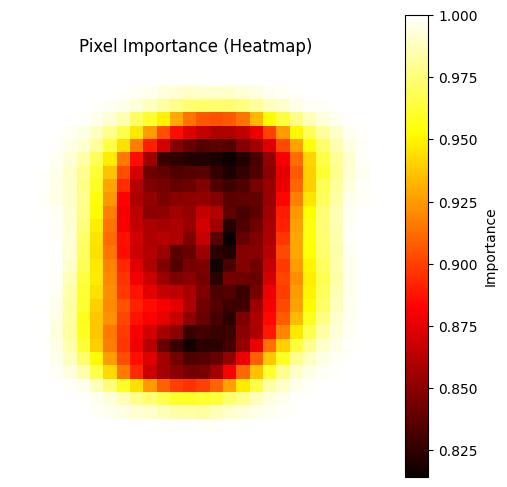

In [35]:
import torch
import matplotlib.pyplot as plt

def plot_importance_map(importance_values, title="Input Neuron Importance"):
    """
    Plots the importance values as a heatmap.

    Args:
        importance_values (torch.Tensor): Importance scores for input neurons (reshaped as 28x28).
        title (str): Title of the plot.
    """
    importance_values = importance_values.cpu().numpy()  # Convert tensor to NumPy

    plt.figure(figsize=(6, 6))
    plt.imshow(importance_values, cmap="hot", interpolation="nearest")
    plt.colorbar(label="Importance")
    plt.title(title)
    plt.axis("off")
    plt.show()

plot_importance_map(importance_scores['input_neurons'], title="Pixel Importance (Heatmap)")


In [41]:
import torch

# Calculate the mean importance score for input neurons
mean_importance = importance_scores['input_neurons'].mean().item()

# Convert the importance tensor to numpy for easy comparison
importance_values = importance_scores['input_neurons'].cpu().numpy()

# Get number of neurons with importance greater than the mean
above_mean = (importance_values > mean_importance).sum()

print(f"Number of input neurons with importance greater than the mean: {above_mean}")


Number of input neurons with importance greater than the mean: 486


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute sum of outgoing weights per neuron and normalize by the number of outgoing weights
l2_outgoing = torch.sum(torch.abs(model.l2.weight), dim=0) / model.l2.weight.size(0)  # 784 input neurons
l3_outgoing = torch.sum(torch.abs(model.l3.weight), dim=0) / model.l3.weight.size(0)  # 128 hidden neurons
l4_outgoing = torch.sum(torch.abs(model.l4.weight), dim=0) / model.l4.weight.size(0)  # 64 hidden neurons

# Compute absolute sum of incoming weights per neuron and normalize by the number of incoming weights
l2_incoming = torch.sum(torch.abs(model.l2.weight), dim=1) / model.l2.weight.size(1)  # 128 hidden neurons
l3_incoming = torch.sum(torch.abs(model.l3.weight), dim=1) / model.l3.weight.size(1)  # 64 hidden neurons
l4_incoming = torch.sum(torch.abs(model.l4.weight), dim=1) / model.l4.weight.size(1)  # 10 output neurons

# Compute total influence for each layer
l1 = l2_outgoing  # Input layer (only outgoing)
l2 = l2_incoming + l3_outgoing  # First hidden layer
l3 = l3_incoming + l4_outgoing  # Second hidden layer
l4 = l4_incoming  # Output layer (only incoming)

# Flatten and combine all values
all_total_sums = np.concatenate([
    l1.detach().cpu().numpy(),  # 784 input neurons
    l2.detach().cpu().numpy(),  # 128 first hidden neurons
    l3.detach().cpu().numpy(),  # 64 second hidden neurons
    l4.detach().cpu().numpy()   # 10 output neurons
])
print(len(all_total_sums))

986


In [10]:
import numpy as np

def round_to_sigfig(x, sig_figs=1):
    if x == 0:
        return 0  # Avoid log(0) errors
    rounded = round(x, -int(np.floor(np.log10(abs(x)))) + (sig_figs - 1))
    return float(f"{rounded:.{sig_figs}g}")  # Convert to string and back to float for precision

# Assuming all_total_sums, l2_outgoing, l2_incoming, l3_outgoing, l3_incoming, l4_outgoing, l4_incoming are already defined

# Step 1: Compute the mean of the absolute values
mean_abs = np.mean(np.abs(all_total_sums))

# Step 2: Compute abs(value) - mean for each element
modified_values = np.abs(all_total_sums) - mean_abs

# Step 3: Create a list of tuples (value, abs(value) - mean, original_index)
indexed_arr = [(val, mod_val, idx) for idx, (val, mod_val) in enumerate(zip(all_total_sums, modified_values))]

# Step 4: Sort by absolute value in descending order to determine new positions
sorted_arr = sorted(indexed_arr, key=lambda x: abs(x[0]), reverse=True)

# Step 5: Assign new positions based on sorted order
labeled_sorted_arr = [(val, mod_val, idx, rank) for rank, (val, mod_val, idx) in enumerate(sorted_arr)]

# Step 6: Convert tensors to NumPy (move to CPU first if necessary)
l2_outgoing_np = l2_outgoing.detach().cpu().numpy()
l3_outgoing_np = l3_outgoing.detach().cpu().numpy()
l4_outgoing_np = l4_outgoing.detach().cpu().numpy()
l2_incoming_np = l2_incoming.detach().cpu().numpy()
l3_incoming_np = l3_incoming.detach().cpu().numpy()
l4_incoming_np = l4_incoming.detach().cpu().numpy()

# Step 7: Flatten outgoing and incoming weight values
outgoing_weights = np.concatenate([l2_outgoing_np, l3_outgoing_np, l4_outgoing_np, np.zeros(10)])
incoming_weights = np.concatenate([np.zeros(784), l2_incoming_np, l3_incoming_np, l4_incoming_np])

# Step 8: Append the correct outgoing/incoming weights and the count of outgoing/incoming weights
final_list = []
layer_sizes = [784, 128, 64, 10]

for i, (val, mod_val, original_index, new_position) in enumerate(labeled_sorted_arr):
    # Determine the number of incoming and outgoing weights
    if original_index < 784:
        num_outgoing = 128  # Outgoing to the first hidden layer
        num_incoming = 0  # No incoming
    elif original_index < 784 + 128:
        num_outgoing = 64  # Outgoing to the second hidden layer
        num_incoming = 784  # Incoming from the first layer
    elif original_index < 784 + 128 + 64:
        num_outgoing = 10  # Outgoing to the output layer
        num_incoming = 128  # Incoming from the second hidden layer
    else:
        num_outgoing = 0  # Output layer has no outgoing
        num_incoming = 64  # Incoming from the second hidden layer

    outgoing_weight = outgoing_weights[original_index]
    incoming_weight = incoming_weights[original_index]

    final_list.append((val, mod_val, original_index, new_position, outgoing_weight, incoming_weight, num_outgoing, num_incoming))

layer_labels = ["l1", "l2", "l3", "l4"]

# Function to determine the layer of a neuron based on its index
def get_layer_label(original_index):
    if original_index < layer_sizes[0]:
        return 1  # Input Layer
    elif original_index < layer_sizes[0] + layer_sizes[1]:
        return 2  # First Hidden Layer
    elif original_index < layer_sizes[0] + layer_sizes[1] + layer_sizes[2]:
        return 3  # Second Hidden Layer
    else:
        return 4

# Add a new column that stores the max between outgoing and incoming weights
final_list_sorted_with_max = [
    (
        value,
        modified_value,
        original_index,
        new_position,
        outgoing_weight,
        incoming_weight,
        num_outgoing,
        num_incoming,
        max(outgoing_weight, incoming_weight),  # New column
        get_layer_label(original_index)
    )
    for value, modified_value, original_index, new_position, outgoing_weight, incoming_weight, num_outgoing, num_incoming in final_list
]

# Step 9: Sort by the new positions
final_list_sorted_with_max = sorted(final_list_sorted_with_max, key=lambda x: x[0], reverse=True)  # Sort by new_position (4th element in tuple)

# Print results
for value, modified_value, original_index, new_position, outgoing_weight, incoming_weight, num_outgoing, num_incoming, max_weight, layer in final_list_sorted_with_max:
    print(f"Value: {value}, -Mean: {modified_value}, Orig: {original_index}, "
          f"New: {new_position}, Out: {outgoing_weight}, In: {incoming_weight}, "
          f"No Out: {num_outgoing}, No In: {num_incoming}, "
          f"L: {layer}, Max: {max_weight}")



Value: 0.2950665354728699, -Mean: 0.2398541420698166, Orig: 951, New: 0, Out: 0.2189006358385086, In: 0.07616589218378067, No Out: 10, No In: 128, L: 3, Max: 0.2189006358385086
Value: 0.28321221470832825, -Mean: 0.22799982130527496, Orig: 968, New: 1, Out: 0.2071804255247116, In: 0.07603178918361664, No Out: 10, No In: 128, L: 3, Max: 0.2071804255247116
Value: 0.280842661857605, -Mean: 0.2256302684545517, Orig: 935, New: 2, Out: 0.19836577773094177, In: 0.08247688412666321, No Out: 10, No In: 128, L: 3, Max: 0.19836577773094177
Value: 0.2502805292606354, -Mean: 0.1950681358575821, Orig: 929, New: 3, Out: 0.1723155528306961, In: 0.07796498388051987, No Out: 10, No In: 128, L: 3, Max: 0.1723155528306961
Value: 0.24774661660194397, -Mean: 0.19253422319889069, Orig: 924, New: 4, Out: 0.17361101508140564, In: 0.07413560897111893, No Out: 10, No In: 128, L: 3, Max: 0.17361101508140564
Value: 0.2423793375492096, -Mean: 0.1871669441461563, Orig: 922, New: 5, Out: 0.16964881122112274, In: 0.072

In [14]:
neg = 0
neg_weight = 0
negneuron = []
for value, modified_value, original_index, new_position, outgoing_weight, incoming_weight, num_outgoing, num_incoming, max_weight, layer in final_list_sorted_with_max:
    if modified_value <= 0:
        neg += 1
        neg_weight += num_outgoing 
        neg_weight += num_incoming
        negneuron.append(original_index)
print(neg, neg_weight, negneuron)

650 83200 [381, 207, 180, 571, 215, 541, 407, 289, 272, 185, 603, 344, 573, 157, 599, 206, 600, 512, 355, 455, 606, 303, 655, 627, 372, 468, 484, 235, 569, 574, 438, 440, 234, 427, 521, 630, 628, 568, 629, 383, 598, 659, 357, 382, 232, 156, 187, 567, 495, 301, 243, 631, 233, 548, 371, 316, 179, 398, 511, 658, 483, 595, 275, 153, 154, 302, 155, 597, 634, 578, 178, 657, 247, 482, 510, 158, 654, 261, 315, 276, 216, 288, 426, 538, 469, 522, 244, 566, 626, 605, 159, 625, 260, 370, 205, 633, 273, 656, 342, 127, 274, 607, 343, 579, 540, 152, 596, 660, 330, 454, 314, 577, 385, 384, 604, 624, 576, 580, 685, 608, 188, 412, 331, 248, 686, 246, 124, 287, 549, 204, 177, 496, 151, 126, 358, 632, 356, 684, 304, 553, 635, 359, 386, 259, 552, 425, 539, 441, 122, 497, 329, 387, 286, 341, 217, 128, 219, 231, 683, 594, 581, 414, 525, 245, 653, 123, 218, 397, 523, 687, 550, 453, 651, 369, 554, 661, 551, 662, 623, 526, 652, 524, 442, 413, 498, 191, 712, 160, 415, 555, 565, 682, 150, 636, 481, 125, 176, 203,

In [12]:
import copy

final_list_sorted_with_max = sorted(final_list_sorted_with_max, key=lambda x: x[4], reverse=True)
final_list_copy = copy.deepcopy(final_list_sorted_with_max)
final_list_copy = sorted(final_list_copy, key=lambda x: x[5], reverse=True)
con = []
neg = 0
pos_weight = 0

for (
    value, modified_value, original_index, new_position,
    outgoing_weight, incoming_weight, num_outgoing, num_incoming,
    max_weight, layer
) in final_list_sorted_with_max:
    if modified_value > 0 and layer <= 2 and pos_weight <= neg_weight:
        for (
            value2, modified_value2, original_index2, new_position2,
            outgoing_weight2, incoming_weight2, num_outgoing2, num_incoming2,
            max_weight2, layer2
        ) in final_list_copy:
            if modified_value2 > 0 and layer2 - layer >= 2:
                inn = original_index2
                innl = layer2
                outn = original_index
                outnl = layer
                con.append([outn, outnl, inn, innl])
                pos_weight += outgoing_weight + incoming_weight2
print(con)
print(pos_weight)

[[784, 2, 977, 4], [784, 2, 979, 4], [784, 2, 982, 4], [784, 2, 981, 4], [784, 2, 983, 4], [784, 2, 984, 4], [784, 2, 985, 4], [784, 2, 978, 4], [784, 2, 980, 4], [784, 2, 976, 4], [789, 2, 977, 4], [789, 2, 979, 4], [789, 2, 982, 4], [789, 2, 981, 4], [789, 2, 983, 4], [789, 2, 984, 4], [789, 2, 985, 4], [789, 2, 978, 4], [789, 2, 980, 4], [789, 2, 976, 4], [866, 2, 977, 4], [866, 2, 979, 4], [866, 2, 982, 4], [866, 2, 981, 4], [866, 2, 983, 4], [866, 2, 984, 4], [866, 2, 985, 4], [866, 2, 978, 4], [866, 2, 980, 4], [866, 2, 976, 4], [867, 2, 977, 4], [867, 2, 979, 4], [867, 2, 982, 4], [867, 2, 981, 4], [867, 2, 983, 4], [867, 2, 984, 4], [867, 2, 985, 4], [867, 2, 978, 4], [867, 2, 980, 4], [867, 2, 976, 4], [845, 2, 977, 4], [845, 2, 979, 4], [845, 2, 982, 4], [845, 2, 981, 4], [845, 2, 983, 4], [845, 2, 984, 4], [845, 2, 985, 4], [845, 2, 978, 4], [845, 2, 980, 4], [845, 2, 976, 4], [905, 2, 977, 4], [905, 2, 979, 4], [905, 2, 982, 4], [905, 2, 981, 4], [905, 2, 983, 4], [905, 2, 

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(28 * 28, 128)  # Input: 784 pixels → Hidden: 128 neurons
        self.l3 = nn.Linear(128, 64)       # Hidden: 128 → Hidden: 64 neurons
        self.l4 = nn.Linear(64, 10)        # Hidden: 64 → Output: 10 (digits 0-9)

        torch.manual_seed(0)  # Set seed for reproducibility
        self.custom = nn.Parameter(torch.randn(1))  
        print(self.custom)

    def forward(self, im):
        l1 = im.view(-1, 28*28)
        l2 = F.relu(self.l2(l1))
        l3 = F.relu(self.l3(l2))
        l4 = self.l4(l3)
        if innl == 4:
            if outnl == 2:
                for i in range(len(im)): 
                    l4[i][0] = l4[i][0] + self.custom * l2[i][outn] 
        return l4

# Initialize model
model = MNIST_Net()
#model.load_state_dict(torch.load("model_weights2.pth"))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



Parameter containing:
tensor([1.5410], requires_grad=True)


MNIST_Net(
  (l2): Linear(in_features=784, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
)

In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def remove_neurons_from_layer(layer, neurons_to_remove):
    """
    Removes specified neurons from a given fully connected layer.
    
    Args:
        layer (nn.Linear): The original layer to modify.
        neurons_to_remove (list): List of neuron indices to remove.

    Returns:
        nn.Linear: A new layer with the specified neurons removed.
    """
    neurons_to_remove = sorted(neurons_to_remove)

    # Extract current weights and biases
    old_weights = layer.weight.detach().clone()
    old_bias = layer.bias.detach().clone()

    # Create a mask to keep only the rows we want
    keep_indices = [i for i in range(old_weights.shape[0]) if i not in neurons_to_remove]

    # Remove the specified rows
    new_weights = old_weights[keep_indices, :]
    new_bias = old_bias[keep_indices]

    # Create new Linear layer with adjusted output size
    new_layer = nn.Linear(layer.in_features, len(keep_indices), bias=True)

    # Copy the modified weights and biases into the new layer
    with torch.no_grad():
        new_layer.weight.copy_(new_weights)
        new_layer.bias.copy_(new_bias)

    return new_layer


class CustomNet(nn.Module):
    def __init__(self, input_size=784, remove_pixels=[], remove_neurons=[]):
        super(CustomNet, self).__init__()

        self.remove_pixels = sorted(remove_pixels)  # Store pixels to remove
        self.remove_neurons = sorted(remove_neurons)  # Store neurons to remove

        # **Step 1: Remove specified neurons from the first hidden layer (l1)**
        self.l1 = nn.Linear(input_size - len(self.remove_pixels), 128)  # Adjusted input size
        self.l1 = remove_neurons_from_layer(self.l1, self.remove_neurons)  # Apply neuron removal
        print(self.l1.weight.shape)

        # **Step 2: Define next layers after neuron removal is applied**
        self.l2 = nn.Linear(self.l1.out_features, 64)  # l2 takes the output from l1
        self.l3 = nn.Linear(self.l2.out_features, 10)  # l3 takes the output from l2

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input (batch_size, 784)

        # **Step 1: Remove selected pixels from input layer**
        if self.remove_pixels:
            keep_indices = [i for i in range(784) if i not in self.remove_pixels]
            x = x[:, keep_indices]  # Keep only non-removed pixels
            print(x.shape)

        # **Step 2: Forward pass through the network**
        l1_out = F.relu(self.l1(x))
        l2_out = F.relu(self.l2(l1_out))
        l3_out = self.l3(l2_out)

        return l3_out


# Example: Removing input pixels (100, 200, 300) and neurons (10, 20, 42) from layer l1
pixels_to_remove = [100, 200, 300]
neurons_to_remove = [10, 20, 42]

# Initialize model with adjusted input size and neurons removed
model = CustomNet(remove_pixels=pixels_to_remove, remove_neurons=neurons_to_remove)

# Example batch of images (batch_size = 64, image_size = 28x28 → flattened to 784)
x = torch.randn(64, 784)

# Forward pass
output = model(x)


torch.Size([125, 781])
torch.Size([64, 781])


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def remove_neurons_from_layer(layer, neurons_to_remove):
    """
    Removes specified neurons from a given fully connected layer.
    
    Args:
        layer (nn.Linear): The original layer to modify.
        neurons_to_remove (list): List of neuron indices to remove.

    Returns:
        nn.Linear: A new layer with the specified neurons removed.
    """
    neurons_to_remove = sorted(neurons_to_remove)

    # Extract current weights and biases
    old_weights = layer.weight.detach().clone()
    old_bias = layer.bias.detach().clone()

    # Create a mask to keep only the rows we want
    keep_indices = [i for i in range(old_weights.shape[0]) if i not in neurons_to_remove]

    # Remove the specified rows
    new_weights = old_weights[keep_indices, :]
    new_bias = old_bias[keep_indices]

    # Create new Linear layer with adjusted output size
    new_layer = nn.Linear(layer.in_features, len(keep_indices), bias=True)

    # Copy the modified weights and biases into the new layer
    with torch.no_grad():
        new_layer.weight.copy_(new_weights)
        new_layer.bias.copy_(new_bias)

    return new_layer


class CustomNet(nn.Module):
    def __init__(self, input_size=784, remove_pixels=[], remove_neurons=[]):
        super(CustomNet, self).__init__()

        self.remove_pixels = remove_pixels  # Store pixels to remove

        # **Step 1: Remove specified neurons from the first hidden layer (l1)**
        self.l2 = nn.Linear(input_size - len(self.remove_pixels), 128)  # Adjusted input size
        self.l2 = remove_neurons_from_layer(self.l2, r2)  # Apply neuron removal

        # **Step 2: Define next layers after neuron removal is applied**
        self.l3 = nn.Linear(self.l2.out_features, 64)  # l2 takes the output from l1
        self.l3 = remove_neurons_from_layer(self.l3, r3)

        self.l4 = nn.Linear(self.l3.out_features, 10)  # l3 takes the output from l2
        self.l4 = remove_neurons_from_layer(self.l4, r4)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input (batch_size, 784)

        # **Step 1: Remove selected pixels from input layer**
        if self.remove_pixels:
            keep_indices = [i for i in range(784) if i not in self.remove_pixels]
            x = x[:, keep_indices] 

        # **Step 2: Forward pass through the network**
        l2_out = F.relu(self.l2(x))
        l3_out = F.relu(self.l3(l2_out))
        l4_out = self.l4(l3_out)

        return l4_out


# Example: Removing input pixels (100, 200, 300) and neurons (10, 20, 42) from layer l1
pixels_to_remove = [x for x in negneuron if x < 784]
r2 = [x - 784 for x in negneuron if x >= 784 and x < 784 + 128]
r3 = [x - 784 - 128 for x in negneuron if x >= 784 + 128 and x < 784 + 128 + 60]
r4 = [x - 784 - 128 - 60 for x in negneuron if x >= 784 + 128 + 60 and x < 784 + 128 + 60 + 10] 

# Initialize model with adjusted input size and neurons removed
model = CustomNet(remove_pixels=pixels_to_remove)

# Example batch of images (batch_size = 64, image_size = 28x28 → flattened to 784)
x = torch.randn(64, 784)

# Forward pass
output = model(x)


In [30]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # images = images.view(-1, 784)
        # keep_indices = [i for i in range(784) if i not in pixels_to_remove]
        # images = images[:, keep_indices]
        # print(images.shape)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 9.97%
